In [2]:
import csv

DATADIRECTORY="./simData"
IMAGEDIRECTORY="./simData/IMG"
DRIVINGLOG=DATADIRECTORY+"/driving_log.csv"
lines=[]
with open(DRIVINGLOG) as csvFile:
    reader=csv.reader(csvFile)
    for line in reader:
        lines.append(line)
print("lines:", len(lines))

import cv2

CENTERIMAGE=0
STEERINGMEASUEMENT=3
CAMERAS=3
# CENTER, LEFT, RIGHT
STERRINGADJUSTMENT=[0, .25, -.25]


lines: 10837


In [3]:
import cv2
import numpy as np
import sklearn

def readImage(imagePathOnRemote):
    filename=imagePathOnRemote.split("/")[-1]
    imagePath=IMAGEDIRECTORY+"/"+filename
    image=cv2.imread(imagePath)
    #print("imagePath:", imagePath, "image.shape:", image.shape)
    return image;

def generator(lines, batchSize=128):
    #print("lines:", len(lines))
    numberOfSamples = len(lines)
    while 1: # Loop forever so the generator never terminates
        lines=sklearn.utils.shuffle(lines) # every epoch
        #print("shuffled lines:", len(lines))
        for offset in range(0, numberOfSamples, batchSize):
            batchOfLines = lines[offset:offset+batchSize]

            images=[]
            steeringMeasurements=[]

            for line in batchOfLines:
                for camera in range(CAMERAS):
                    imagePathOnRemote=line[camera]
                    image=readImage(imagePathOnRemote)
                    if (image is None):
                        print ("line:", line)
                        print("image:", image, ", imagePath:", imagePath)
                        exit
                    images.append(image)
                    steering=float(line[STEERINGMEASUEMENT])+STERRINGADJUSTMENT[camera]
                    steeringMeasurements.append(steering)
                    images.append(cv2.flip(image,1))
                    steeringMeasurements.append(steering*-1)
                    assert len(images)==len(steeringMeasurements)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(steeringMeasurements)
            assert len(X_train)==len(y_train)
            #print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
            #print("X_train[0].shape:", X_train[0].shape)
            yield sklearn.utils.shuffle(X_train, y_train)

In [4]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print("train_samples:", len(train_samples), "validation_samples:", len(validation_samples))
print("train_samples[0]:",len(train_samples[0]))

# compile and train the model using the generator function
train_generator = generator(train_samples, batchSize=128)
validation_generator = generator(validation_samples, batchSize=128)

train_samples: 8669 validation_samples: 2168
train_samples[0]: 7


In [19]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Lambda
from keras.layers import Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras as keras

sampleImage=readImage(lines[0][0])
print("sampleImage.shape:", sampleImage.shape)
XtrainInputShape=sampleImage.shape[0:len(sampleImage.shape)]
print ("XtrainInputShape:", XtrainInputShape)

model = Sequential()
model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=XtrainInputShape, output_shape=XtrainInputShape))
#model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=(3,80,320), output_shape=(3,80,320)))

model.add(Cropping2D(cropping=((70,25),(0,0))))

# nvidia model
model.add(Convolution2D(24, 5, 5, subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(36, 5, 5, subsample=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))

model.add(Flatten())

model.add(Dense(100))
model.add(Dropout(.2))

model.add(Dense(50))
model.add(Dense(10))

##
model.add(Dense(1))

adamOptimizer=keras.optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=adamOptimizer)
#model.compile(loss='mse', optimizer='adam')

history_object=model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator,
                                   nb_val_samples=len(validation_samples), nb_epoch=50)

#adamOptimizer=keras.optimizers.Adam(lr=0.0001)
#model.compile(optimizer=adamOptimizer, loss='mse', metrics=['accuracy'])
#history_object=model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=50)

import datetime

modelFilename=datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")+".model"
print ("saving model as:", modelFilename)
model.save(modelFilename)

sampleImage.shape: (160, 320, 3)
XtrainInputShape: (160, 320, 3)
Epoch 1/50
8448/8669 [============================>.] - ETA: 0s - loss: 0.2467

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


9216/8669 [===============================] - 23s - loss: 0.2377 - val_loss: 0.0671
Epoch 2/50
9216/8669 [===============================] - 22s - loss: 0.0987 - val_loss: 0.0729
Epoch 3/50
9216/8669 [===============================] - 22s - loss: 0.0683 - val_loss: 0.0589
Epoch 4/50
9006/8669 [===============================] - 22s - loss: 0.0611 - val_loss: 0.0681
Epoch 5/50
9216/8669 [===============================] - 22s - loss: 0.0556 - val_loss: 0.0654
Epoch 6/50
9216/8669 [===============================] - 22s - loss: 0.0456 - val_loss: 0.0653
Epoch 7/50
9216/8669 [===============================] - 22s - loss: 0.0466 - val_loss: 0.0667
Epoch 8/50
9216/8669 [===============================] - 22s - loss: 0.0471 - val_loss: 0.0651
Epoch 9/50
9216/8669 [===============================] - 22s - loss: 0.0397 - val_loss: 0.0587
Epoch 10/50
9006/8669 [===============================] - 21s - loss: 0.0417 - val_loss: 0.0681
Epoch 11/50
9216/8669 [===============================] - 22

dict_keys(['loss', 'val_loss'])
key: loss , values: [0.23773318032423654, 0.098741707081596061, 0.06831677258014679, 0.0610889039243721, 0.055612627106408276, 0.045595836204787098, 0.046607847015062966, 0.047141370053092636, 0.039746838000913463, 0.041714504390935117, 0.039378713505963482, 0.039382968097925186, 0.03864705997208754, 0.0338353697831432, 0.037307107646134915, 0.036330412762860455, 0.035065973798433937, 0.034179764334112406, 0.032479600204775728, 0.030930135243882734, 0.033031338449818225, 0.028358835571755964, 0.031831133489807449, 0.033346988260746002, 0.030639516810576122, 0.032139749887088932, 0.028880483323806209, 0.031141513958573341, 0.030228679378827412, 0.028716865616540115, 0.028404993781199057, 0.028137359019867744, 0.028564858871201675, 0.027950188145041466, 0.027589847644170124, 0.02705046022310853, 0.028396526506791513, 0.026365501809862753, 0.02608640616138776, 0.02783611121897896, 0.027637793682515621, 0.026726184568057459, 0.02685015896956126, 0.0253601649

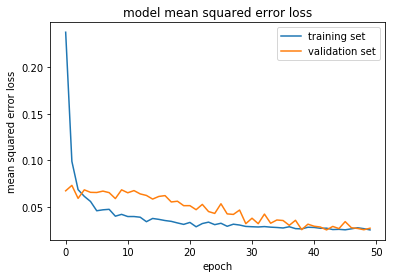

In [20]:
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())
for key in history_object.history.keys():
    print ("key:", key,", values:", history_object.history[key])

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()